In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory
from sklearn.model_selection import train_test_split
import mlflow

In [2]:
# hyperparameters
NUM_EPOCHS = 25
BATCH_SIZE = 4
LAYERS_TRAINED = 1

# use balanced torch imagefolder dataset
fraction = 0.33
experiment = 'upperlower'
target_num_of_classes = 2

In [3]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Grayscale(3),
        transforms.RandomResizedCrop(224, scale=(0.9, 1.0)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Grayscale(3),
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}


data_dir = f'/home/riikoro/fossil_data/tooth_samples/torch_imagefolder_2/{experiment}'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=0)
              for x in ['train', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
class_names

['lower', 'upper']

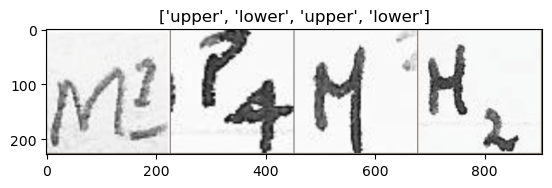

In [4]:

def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

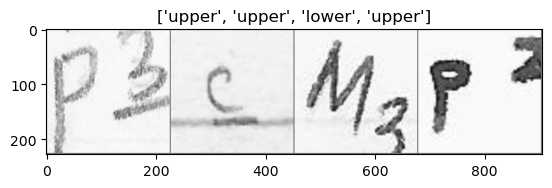

In [5]:
# Get a batch of test data
inputs, classes = next(iter(dataloaders['test']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [6]:
model_conv = torchvision.models.vgg16(weights='DEFAULT')
for param in list(model_conv.parameters())[:-1*LAYERS_TRAINED]:
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.classifier[6].in_features
model_conv.classifier[6] = nn.Linear(num_ftrs, target_num_of_classes)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.classifier[6].parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

for param in model_conv.parameters():
    print(param.requires_grad)
model_conv

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /home/riikoro/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:17<00:00, 31.4MB/s] 


False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
True
True


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [7]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    best_train_acc = 0.0
    best_test_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
            
            if phase == 'test' and epoch_acc > best_test_acc:
                best_test_acc = epoch_acc.item()
            if phase == 'train' and epoch_acc > best_train_acc:
                best_train_acc = epoch_acc.item()

        print()

    print(f'Best val Acc: {best_test_acc:4f}')

    return model, best_train_acc, best_test_acc

In [8]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [9]:
model_conv, train_acc, test_acc = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=NUM_EPOCHS)

Epoch 0/24
----------
train Loss: 0.9235 Acc: 0.6423
test Loss: 0.3754 Acc: 0.8000

Epoch 1/24
----------
train Loss: 0.8692 Acc: 0.6958
test Loss: 0.3121 Acc: 0.9000

Epoch 2/24
----------
train Loss: 0.7403 Acc: 0.7859
test Loss: 0.5154 Acc: 0.7750

Epoch 3/24
----------
train Loss: 0.6176 Acc: 0.7972
test Loss: 0.4357 Acc: 0.8500

Epoch 4/24
----------
train Loss: 0.7494 Acc: 0.7746
test Loss: 0.3504 Acc: 0.8500

Epoch 5/24
----------
train Loss: 0.5823 Acc: 0.8028
test Loss: 0.7395 Acc: 0.6750

Epoch 6/24
----------
train Loss: 0.8346 Acc: 0.7634
test Loss: 0.3332 Acc: 0.8500

Epoch 7/24
----------
train Loss: 0.6248 Acc: 0.8141
test Loss: 0.2482 Acc: 0.9000

Epoch 8/24
----------
train Loss: 0.4919 Acc: 0.8366
test Loss: 0.2326 Acc: 0.9000

Epoch 9/24
----------
train Loss: 0.5485 Acc: 0.8338
test Loss: 0.3048 Acc: 0.8750

Epoch 10/24
----------
train Loss: 0.5157 Acc: 0.8310
test Loss: 0.2330 Acc: 0.8750

Epoch 11/24
----------
train Loss: 0.4597 Acc: 0.8563
test Loss: 0.2659 Acc

In [12]:
print(test_acc)

0.925


In [13]:
print(train_acc)

0.8985915492957747


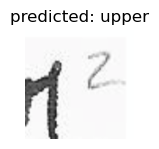

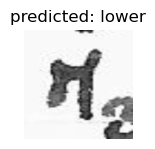

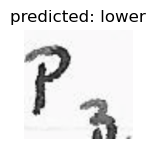

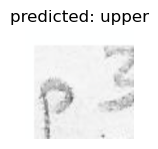

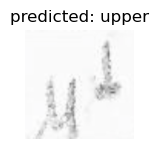

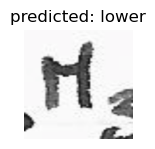

In [14]:

visualize_model(model_conv)

plt.ioff()
plt.show()

In [15]:
model_pt_filename = f'{experiment}.pt'
torch.save(model_conv, model_pt_filename)

In [16]:
%env MLFLOW_TRACKING_URI=sqlite:///../../mlflow.db
mlflow.set_experiment(experiment)

params = {
    'data_v': [3,4,5],
    'train_size': dataset_sizes['train'],
    'test_size': dataset_sizes['test'],
    'batch_size': BATCH_SIZE,
    'num_epochs': NUM_EPOCHS,
    'base_model_path': 'torchvision.models.vgg16',
    'preprocessing': 'grayscaling, normalization, random crop',
    'layers_trained': LAYERS_TRAINED
}

# Start an MLflow run
with mlflow.start_run():
    # Log the hyperparameters
    mlflow.log_params(params)

    # Log the loss metric
    mlflow.log_metric("most frequent class occurence fraction", fraction)
    mlflow.log_metric("training accuracy", train_acc)
    mlflow.log_metric("test accuracy", test_acc)

    mlflow.log_artifact(model_pt_filename)

    # Set a tag that we can use to remind ourselves what this run was for
    mlflow.set_tag("info", "VGG16, basic finetuning")

env: MLFLOW_TRACKING_URI=sqlite:///../../mlflow.db
